In [ ]:
import numpy as np 
import time
import types
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import librosa
import librosa.display
import soundfile as sf

import os
from tqdm import tqdm
import time
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes, device, classes=None):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)
    self.device = device
    self.classes = classes

  def forward(self, x):
    # Set initial hidden and cell states
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device) 
    c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device) 
    
    # Forward propagate LSTM
    out, _ = self.lstm(x, (h0, c0))  # shape = (batch_size, seq_length, hidden_size)
    
    # Decode the hidden state of the last time step
    out = self.fc(out[:, -1, :])
    return out

## Augment data

In [ ]:
import glob

def rand_uniform(bound, size=None):
    l, r = bound[0], bound[1]
    return np.random.uniform(l, r, size=size)

def is_list_or_tuple(obj):
    return isinstance(obj, list) or isinstance(obj, tuple)

def to_tuple(val, left_bound=None):
    if isinstance(val, tuple):
        return val 
    if isinstance(val, list):
        return (val[0], val[1])
    else:
        if left_bound is None:
            left_bound = -val
            return (-val, val)
        else:
            return (left_bound, val)
    
def get_filenames(folder, file_types=('*.wav',)):
    filenames = []
    
    if not isinstance(file_types, tuple):
        file_types = [file_types]
        
    for file_type in file_types:
        filenames.extend(glob.glob(folder + "/" + file_type))
    filenames.sort()
    return filenames

def read_audio(filename, dst_sample_rate=16000):
    
    data, sample_rate = librosa.load(filename) 
    
    if (dst_sample_rate is not None) and (dst_sample_rate != sample_rate):
        data = librosa.core.resample(data, sample_rate, dst_sample_rate)
        sample_rate = dst_sample_rate
        
    return data, sample_rate
            
class Augmenter(object):
    
    def __init__(self, transforms, prob_to_aug=1):
        self.transforms = transforms 
        self.prob_to_aug = prob_to_aug
        
    def __call__(self, audio):
        if np.random.random()>self.prob_to_aug:
            return audio 
        else:
            for transform in self.transforms:
                audio = transform(audio)
            return audio 

    # Add noise 
    class Noise(object):
        def __init__(self, noise_folder, prob_noise=0.5, intensity=(0, 0.5)):
            self.intensity = to_tuple(intensity)
            
            # Load noises 
            fnames = get_filenames(noise_folder)
            noises = []
            for name in fnames:
                noise, rate = read_audio(filename=name)
                noise = librosa.util.normalize(noise) 
                noise = self.repeat_pad_to_time(noise, rate, time=10)
                noises.append(noise)
            self.noises = noises
            self.prob_noise = prob_noise
            
        def __call__(self, audio):
            if np.random.random() > self.prob_noise: 
                return audio

            data = audio.data
            
            # add noise
            noise = self.randomly_pick_a_noise() * rand_uniform(self.intensity)
            data = data + random_crop(noise, len(data))
            data[data>+1] = +1
            data[data<-1] = -1
                
            audio.data = data
            assert len(audio.data) > 0
            return audio
        
        def randomly_pick_a_noise(self):
            i = np.random.randint(len(self.noises))
            return self.noises[i]
        
        def repeat_pad_to_time(self, noise, sample_rate, time):
            # repeat the noise data, to make it longer than time
            N = time * sample_rate
            n = len(noise)
            if n < N:
                noise = np.tile(noise, 1+(N//n))
            return noise
             

    # Shift audio 
    class Shift(object):
        def __init__(self, rate=None, keep_size=False):
            self.rate = None
            if rate:
                self.rate = to_tuple(rate)

            self.keep_size = keep_size
            
        def __call__(self, audio):
            if self.rate:
                rate = rand_uniform(self.rate)
                time = rate * audio.get_len_s() 
                
            n = abs(int(time * audio.sample_rate)) 
            data = audio.data
            
            # Shift audio data
            if time > 0 or n == 0: 
                data = data[n:]
            else:
                data = data[:-n]
            
            # Add padding
            if self.keep_size:
                z = np.zeros(n)
                if time>0: # pad at left
                    data = np.concatenate((z, data))
                else:
                    data = np.concatenate((data, z))

            audio.data = data
            return audio
         

    # Pad zeros randomly at left or right 
    class PadZeros(object):
        def __init__(self, time=None):
            self.time = None
            
            if time: # shift time = time
                self.time = to_tuple(time, left_bound=0)
            
        def __call__(self, audio):
            
            if self.time:
                time = rand_uniform(self.time) # seconds
                
            n = abs(int(time * audio.sample_rate))
            data = audio.data
            
            # Shift audio data
            if np.random.random() < 0.5:
                data = np.concatenate(( data, np.zeros(n, ) ))
            else:
                data = np.concatenate(( np.zeros(n, ), data ))

            # return
            audio.data = data
            return audio
        
    # Amplify audio by a rate
    class Amplify(object):
        def __init__(self, rate=(0.2, 2)):
            assert is_list_or_tuple(rate)
            self.rate = to_tuple(rate)
             
        def __call__(self, audio):
            rate = rand_uniform(self.rate)
            data = audio.data * rate
            if rate > 1: 
                data[data>+1] = +1
                data[data<-1] = -1
                
            audio.data = data
            return audio

In [ ]:
Aug = Augmenter
aug = Aug([        
        Aug.Shift(rate=0.2, keep_size=False), 
        Aug.PadZeros(time=(0, 0.3)),
        Aug.Amplify(rate=(0.5, 1.2)),
        Aug.Noise(noise_folder="/content/drive/MyDrive/xu ly tieng noi/noises/", prob_noise=0.8, intensity=(0.1, 0.4)),
    ], prob_to_aug=0.8)

## Data Loader

In [ ]:
def normalize(feature):
  normalized = np.full_like(feature, 0)
  for i in range(feature.shape[1]):
    normalized[:,i] = feature[:,i] - np.mean(feature[:,i]) # đưa trung bình về 0
    normalized[:,i] = normalized[:,i] / np.max(np.abs(normalized[:,i])) # đưa khoảng giá trị về [-1, 1]
  return normalized

class AudioClass(object):
  def __init__(self, filename, sample_rate=None, n_mfcc=20):
    self.filename = filename
    self.n_mfcc = n_mfcc
    self.data, self.sample_rate = librosa.load(filename)

    self.mfcc = self.compute_mfcc()

  def get_len_s(self): # audio length in seconds
    return len(self.data)/self.sample_rate

  def resample(self, new_sample_rate):
    self.data = librosa.core.resample(self.data, self.sample_rate, new_sample_rate)
    self.sample_rate = new_sample_rate

  def compute_mfcc(self, n_mfcc=None):
    if n_mfcc is None:
        n_mfcc = self.n_mfcc
    if self.n_mfcc is None:
        self.n_mfcc = n_mfcc

    mfcc = librosa.feature.mfcc(
            y=self.data,
            sr=self.sample_rate,
            n_mfcc=n_mfcc,
        )
    delta = librosa.feature.delta(mfcc, order=2, mode='nearest')
    ft = [normalize(mfcc)]
    ft.append(delta)
    ft = np.concatenate(ft, axis=0)
    return ft


class AudioDataset(Dataset):
  def __init__(self, root, labels, transform=None):
    self.all_file = []
    self.all_labels = labels
    self.transform = transform

    all_names = os.listdir(root)
    for name in all_names:
      for label in labels:
        path = os.path.join(root, name, label) 
        self.all_file += [os.path.join(path, i) for i in os.listdir(path)]

  def __len__(self):
    return len(self.all_file)

  def __getitem__(self, idx):
    name_file = self.all_file[idx]
    audio = AudioClass(name_file)
    if self.transform:
      audio = self.transform(audio)
    label = name_file.split('/')[-2]
    X = torch.Tensor(audio.mfcc.T)
    Y = self.all_labels.index(label)

    return X, Y

  def set_transform(self, transform):
    self.transform = transform


In [ ]:
root = '/content/data'
all_label = ['trai', 'phai', 'len', 'xuong']

In [ ]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split, random_state=7)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

dataset = train_val_dataset(AudioDataset(root, all_label))
train_data = dataset['train']
train_data.dataset.set_transform(aug)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=1)
test_data = dataset['val']
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=1)

In [ ]:
x, y = next(iter(train_loader))
print(x.shape)

torch.Size([1, 23, 40])


## Training

In [ ]:
def train_fn(model, optimizer, loss_fn, dataloader, device='cpu'):
  mean_loss = []
  model.train()

  for feature, label in tqdm(dataloader):
    feature = feature.float().to(device)
    label = label.long().to(device)

    optimizer.zero_grad()

    preds = model(feature)
    loss = loss_fn(preds, label)
    mean_loss.append(loss.item())

    loss.backward()
    optimizer.step()

  print(f"Mean loss: {sum(mean_loss) / len(mean_loss)}")
  return sum(mean_loss) / len(mean_loss)

def eval_fn(model, loss_fn, dataloader, device='cpu'):
  model.eval()
  cr = 0
  tt = 0
  for feature, label in tqdm(dataloader):
    feature = feature.float().to(device)
    label = label.long().to(device)
    with torch.no_grad():
      pred = model(feature)
      _, pred_label = torch.max(pred, dim=1)
      tt += label.size(0)
      cr += (pred_label == label).sum().item()

  eval_accu = cr / tt
  return eval_accu

def predict(wav_file, model, all_label=None, device='cpu'):
  t0 = time.time()
  audio, sr = librosa.load(wav_file)
  clip = librosa.effects.trim(audio, top_db= 10)
  new_audio = clip[0]
  mfcc = librosa.feature.mfcc(
            y=clip[0],
            n_mfcc=20,
        )
  mfcc = normalize(mfcc)
  t1 = time.time()
  print('Preprocess : %f' % (t1 - t0))
  print('-----------------')
  # model.eval().to(device)
  t2 = time.time()
  input = torch.Tensor(mfcc.T).unsqueeze(0)
  _, label = torch.max(model(input.to(device)), dim=1)
  t3 = time.time()

  print('Predict: %f' % (t3 - t2))
  print('-------------------')
  if all_label is None:
    return label
  
  return all_label[label]

def save_checkpoint(epoch, state, filename='/content/drive/MyDrive/xu ly tieng noi/checkpoint/ver3.pth'):
  torch.save(state, filename)

def load_checkpoint(device, filename='/content/drive/MyDrive/xu ly tieng noi/checkpoint/ver3.pth'):
  checkpoint = torch.load(filename, map_location=device)
  model = RNN(input_size=20, hidden_size=64, num_layers=3, num_classes=4, device=device)
  model.load_state_dict(checkpoint['model'])
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_dc)
  optimizer.load_state_dict(checkpoint['optimizer'])

  return (model, optimizer)

In [ ]:
class EarlyStopping():
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_acc = None
        self.early_stop = False
    def __call__(self, val_acc):
        if self.best_acc == None:
            self.best_acc = val_acc
        elif self.best_acc - val_acc < self.min_delta:
            self.best_acc = val_acc
            # reset counter if validation acc improves
            self.counter = 0
        elif self.best_acc - val_acc > self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [ ]:
device = torch.device('cpu')
model = RNN(input_size=40, hidden_size=64, num_layers=3, num_classes=4, device=device)
print(model)

RNN(
  (lstm): LSTM(40, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)


In [ ]:
lr = 1e-4
weight_dc = 0.0

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_dc)

In [ ]:
epoches = 10
best_acc = 0.
# device = torch.device('cuda')
model.to(device)
early_stopping = EarlyStopping()

for epoch in range(epoches):
  print('Training....')
  train_loss = train_fn(model, optimizer, loss_fn, train_loader, device)
  print('Evaluating train set....')
  train_acc = eval_fn(model, loss_fn, train_loader, device)
  print('Train acc: ', train_acc)
  print('Evaluating test set...')
  test_acc = eval_fn(model, loss_fn, test_loader, device)
  print('Test acc: ', test_acc)
  if best_acc < test_acc:
    print('Better_ver saved')
    state_dict = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'loss': train_loss,
    'acc': test_acc
    }
    save_checkpoint(None, state_dict)
    best_acc = test_acc
  early_stopping(test_acc)
  if early_stopping.early_stop:
      break

Training....


100%|██████████| 2889/2889 [02:23<00:00, 20.13it/s]


Mean loss: 0.507182653194539
Evaluating train set....


100%|██████████| 2889/2889 [01:37<00:00, 29.69it/s]


Train acc:  0.9595015576323987
Evaluating test set...


100%|██████████| 723/723 [00:26<00:00, 27.30it/s]


Test acc:  0.9474412171507607
Better_ver saved
Training....


100%|██████████| 2889/2889 [02:22<00:00, 20.31it/s]


Mean loss: 0.07887196595764111
Evaluating train set....


100%|██████████| 2889/2889 [01:37<00:00, 29.72it/s]


Train acc:  0.9923849082727587
Evaluating test set...


100%|██████████| 723/723 [00:24<00:00, 29.24it/s]


Test acc:  0.983402489626556
Better_ver saved
Training....


100%|██████████| 2889/2889 [02:18<00:00, 20.89it/s]


Mean loss: 0.0391623746774905
Evaluating train set....


100%|██████████| 2889/2889 [01:37<00:00, 29.64it/s]


Train acc:  0.986846659743856
Evaluating test set...


100%|██████████| 723/723 [00:25<00:00, 28.41it/s]


Test acc:  0.9723374827109267
INFO: Early stopping counter 1 of 3
Training....


100%|██████████| 2889/2889 [02:21<00:00, 20.45it/s]


Mean loss: 0.03138680855615284
Evaluating train set....


100%|██████████| 2889/2889 [01:39<00:00, 29.07it/s]


Train acc:  0.9961924541363794
Evaluating test set...


100%|██████████| 723/723 [00:25<00:00, 28.36it/s]


Test acc:  0.9820193637621023
INFO: Early stopping counter 2 of 3
Training....


100%|██████████| 2889/2889 [02:20<00:00, 20.55it/s]


Mean loss: 0.02480596678995412
Evaluating train set....


100%|██████████| 2889/2889 [01:39<00:00, 29.18it/s]


Train acc:  0.995846313603323
Evaluating test set...


100%|██████████| 723/723 [00:25<00:00, 28.79it/s]


Test acc:  0.9875518672199171
Better_ver saved
Training....


100%|██████████| 2889/2889 [02:18<00:00, 20.89it/s]


Mean loss: 0.015497274674281289
Evaluating train set....


100%|██████████| 2889/2889 [01:36<00:00, 29.78it/s]


Train acc:  0.9986154378677743
Evaluating test set...


100%|██████████| 723/723 [00:24<00:00, 29.04it/s]


Test acc:  0.9889349930843707
Better_ver saved
Training....


100%|██████████| 2889/2889 [02:18<00:00, 20.85it/s]


Mean loss: 0.016251537763384193
Evaluating train set....


100%|██████████| 2889/2889 [01:35<00:00, 30.28it/s]


Train acc:  0.9968847352024922
Evaluating test set...


100%|██████████| 723/723 [00:26<00:00, 27.33it/s]


Test acc:  0.9889349930843707
Training....


100%|██████████| 2889/2889 [02:15<00:00, 21.27it/s]


Mean loss: 0.009608549283023255
Evaluating train set....


100%|██████████| 2889/2889 [01:37<00:00, 29.76it/s]


Train acc:  0.9996538594669436
Evaluating test set...


100%|██████████| 723/723 [00:24<00:00, 28.95it/s]


Test acc:  0.9889349930843707
Training....


100%|██████████| 2889/2889 [02:17<00:00, 20.96it/s]


Mean loss: 0.006938807617206014
Evaluating train set....


100%|██████████| 2889/2889 [01:37<00:00, 29.66it/s]


Train acc:  0.9993077189338871
Evaluating test set...


100%|██████████| 723/723 [00:24<00:00, 29.23it/s]


Test acc:  0.9903181189488244
Better_ver saved
Training....


100%|██████████| 2889/2889 [02:17<00:00, 21.06it/s]


Mean loss: 0.008573573336898212
Evaluating train set....


100%|██████████| 2889/2889 [01:37<00:00, 29.72it/s]


Train acc:  0.9993077189338871
Evaluating test set...


100%|██████████| 723/723 [00:24<00:00, 29.08it/s]

Test acc:  0.9903181189488244


In [ ]:
loss = [0.8419548123739673, 0.366685815545572, 0.23426961635509244, 0.17188859221769845, 0.13896896700486322, 0.12019819461930913,
        0.1053650925664812, 0.10937802457890072, 0.08840000305829541, 0.09100761646067584]
train_acc = [0.805122879889235, 0.9169262720664589, 0.9273104880581516, 0.9536171685704395, 0.9556940117687781, 0.9709241952232607,
            0.9747317410868813, 0.9806161301488404, 0.9858082381446868, 0.9747317410868813]
test_acc = [0.7800829875518672, 0.9059474412171508, 0.9073305670816044, 0.946058091286307, 0.941908713692946, 0.9626556016597511,
            0.9612724757952974, 0.9681881051175657, 0.9737206085753803, 0.9764868603042877]

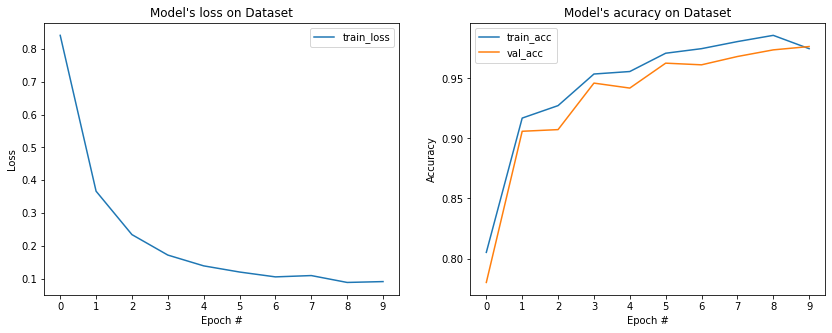

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.rcParams["figure.figsize"] = (14,5)
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(loss, label="train_loss")
ax1.set_title("Model's loss on Dataset")
ax1.set_xlabel("Epoch #")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))


ax2.plot(train_acc, label="train_acc")
ax2.plot(test_acc, label="val_acc")
ax2.set_title("Model's acuracy on Dataset")
ax2.set_xlabel("Epoch #")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="upper left")
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('/content/drive/MyDrive/xu ly tieng noi/report/report_ver3.jpg')

## Test model

In [ ]:
lr = 1e-4
weight_dc = 0.0
device = torch.device('cuda')
model, optim = load_checkpoint(device, '/content/drive/MyDrive/xu ly tieng noi/checkpoint/ver2.pth')

In [ ]:
test_acc = eval_fn(model, loss_fn, test_loader, device)
print('Test acc: ', test_acc)

In [ ]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
audio, sr = get_audio()

In [ ]:
import scipy
scipy.io.wavfile.write('recording.wav', sr, audio)

In [ ]:
label = predict('/content/recording.wav', model, device=device)
print(label)

Preprocess : 0.112727
-----------------
Predict: 0.002012
-------------------
tensor([1], device='cuda:0')


In [ ]:
all_label

['trai', 'phai', 'len', 'xuong']

In [ ]:
audio.shape

(76734,)

In [ ]:
clip = librosa.effects.trim(audio, top_db= 10)
clip[0].shape

(7680,)

In [ ]:
scipy.io.wavfile.write('recording_clip.wav', sr, clip[0])

In [ ]:
Audio('recording_clip.wav')

In [ ]:
label = predict('/content/recording_clip.wav', model, device=device)
print(label)

In [ ]:
def filter_by_average(arr, N):
   cumsum = np.cumsum(np.insert(arr, 0, 0)) 
   return (cumsum[N:] - cumsum[:-N]) / N

def remove_silent_prefix_by_time_domain(data, 
                                        sample_rate, 
                                        threshold=0.4, 
                                        window_s=0.1, 
                                        padding_s=0.2):
	window_size = int(window_s * sample_rate)
	trend = filter_by_average(abs(data), window_size)
	start_idx = np.argmax(trend > threshold)
	start_idx = max(0, start_idx + window_size//2 - int(padding_s*sample_rate))
	return data[start_idx:]

def normalize(audio):
	audio = audio - np.mean(audio)
	audio = audio/np.max(audio)
	return audio

# import librosa
# audio, sr = librosa.load('/content/recording.wav')
# normalized = normalize(audio)
# audio1 = remove_silent_prefix_by_time_domain(normalized, sr)

In [ ]:
mfcc = librosa.feature.mfcc(
            y=clip[0],
            n_mfcc=20,
        )
mfcc = normalize(mfcc)